Ce notebook utilise un modèle RoBERTa pré-entraîné pour l'analyse de sentiments
sur les avis touristiques de Marrakech.

## Objectifs :
- Utiliser le modèle cardiffnlp/twitter-roberta-base-sentiment-latest
- Appliquer le modèle sur le texte brut des avis
- Mapper les sorties en labels : Negative / Neutral / Positive
- Comparer les prédictions avec les labels réels
- Évaluer Accuracy, Precision, Recall, F1-score
- Visualiser la matrice de confusion

RoBERTa est plus performant que VADER sur les textes nuancés et contextuels.

In [9]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm


In [10]:
# Nom du modèle
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Chargement tokenizer et modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Device (GPU si dispo)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Mapping des labels
label_mapping = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Chargement des données
#df_text = pd.read_csv('../data/processed/X_train.csv')
#df_label = pd.read_csv('../data/processed/y_train.csv')

df = pd.read_csv('../data/raw/dataset_marrakech_english.csv')
df = df.dropna().reset_index(drop=True)

# Colonnes correctes
text_column = 'review'
label_column = 'sentiment_label'

texts = df[text_column].astype(str).tolist()

print(f"Nombre d'avis à traiter : {len(texts)}")
df.head()


Nombre d'avis à traiter : 6282


,ID,review,sentiment_label
0,1,Just got back from Marrakech and I'm still ree...,Positive
1,2,"Meh, Jemaa el-Fna square was okay, I guess. To...",Neutral
2,3,The architecture in Marrakech is literally wow...,Positive
3,4,Got scammed by a taxi driver near Majorelle Ga...,Negative
4,5,"The locals were so friendly and welcoming, it ...",Positive


In [12]:
def predict_sentiment_batch(texts, batch_size=16):
    predictions = []
    model.eval()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        predictions.extend([label_mapping[p] for p in preds])

    return predictions


In [13]:
df['roberta_sentiment'] = predict_sentiment_batch(texts)

df[[text_column, label_column, 'roberta_sentiment']].head(10)


100%|██████████| 393/393 [02:35<00:00,  2.52it/s]


,review,sentiment_label,roberta_sentiment
0,Just got back from Marrakech and I'm still ree...,Positive,Positive
1,"Meh, Jemaa el-Fna square was okay, I guess. To...",Neutral,Neutral
2,The architecture in Marrakech is literally wow...,Positive,Positive
3,Got scammed by a taxi driver near Majorelle Ga...,Negative,Negative
4,"The locals were so friendly and welcoming, it ...",Positive,Positive
5,"The heat in Marrakech is no joke, don't forget...",Neutral,Positive
6,"Our riad was adorable, but the noise from the ...",Neutral,Positive
7,Just had the best tagine of my life at a small...,Positive,Positive
8,"The Atlas Mountains were breathtaking, definit...",Positive,Positive
9,Jemaa el-Fna square at night is a whole differ...,Positive,Positive


In [14]:
y_true = df[label_column]
y_pred = df['roberta_sentiment']

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy RoBERTa : {accuracy:.4f}\n")

print("Classification Report :\n")
print(classification_report(y_true, y_pred))


Accuracy RoBERTa : 0.7768

Classification Report :

              precision    recall  f1-score   support

    Negative       0.71      0.96      0.82      1217
     Neutral       0.88      0.23      0.36      1726
    Positive       0.79      0.99      0.88      3339

    accuracy                           0.78      6282
   macro avg       0.79      0.73      0.69      6282
weighted avg       0.80      0.78      0.73      6282



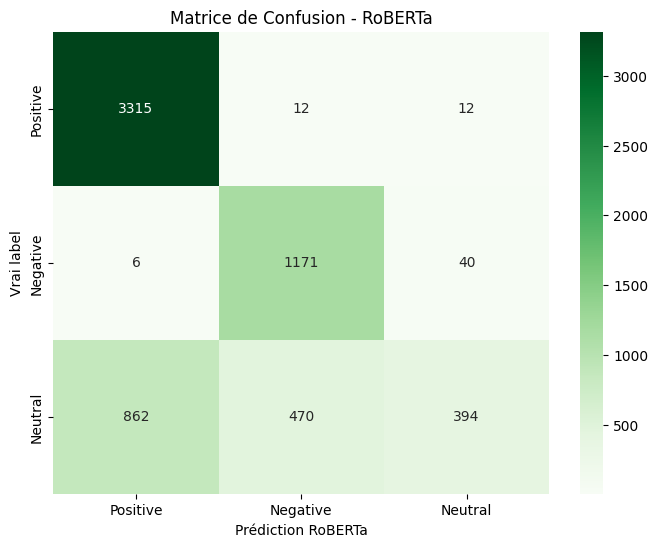

In [15]:
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=['Positive', 'Negative', 'Neutral']
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Positive', 'Negative', 'Neutral'],
    yticklabels=['Positive', 'Negative', 'Neutral']
)

plt.title('Matrice de Confusion - RoBERTa')
plt.xlabel('Prédiction RoBERTa')
plt.ylabel('Vrai label')
plt.show()


In [16]:
errors = df[df[label_column] != df['roberta_sentiment']]

print(f"Nombre d'erreurs RoBERTa : {len(errors)}\n")

errors.sample(10)[[text_column, label_column, 'roberta_sentiment']]


Nombre d'erreurs RoBERTa : 1402



,review,sentiment_label,roberta_sentiment
5511,"The locals can be a bit pushy, but overall the...",Neutral,Positive
3959,"Majorelle Garden was stunning, but the heat wa...",Neutral,Negative
2728,"Our experience in Marrakech was okay, not bad ...",Neutral,Negative
5541,"Majorelle Garden was lovely, but it was too cr...",Neutral,Positive
1272,The locals in Marrakech can be a bit pushy whe...,Neutral,Negative
1081,Best advice: stay hydrated and wear sunscreen. 🌞,Neutral,Positive
4441,"The tagine was delicious, but the portion was ...",Neutral,Positive
6097,"The food prices can be a bit steep, but the qu...",Neutral,Positive
5530,"The heat in Marrakech is no joke, make sure to...",Neutral,Negative
1804,The architecture in Marrakech is a mix of old ...,Neutral,Positive


100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


RoBERTa - Test Set
              precision    recall  f1-score   support

    Negative       0.69      0.93      0.79       244
     Neutral       0.84      0.25      0.38       345
    Positive       0.80      0.99      0.89       668

    accuracy                           0.78      1257
   macro avg       0.78      0.72      0.69      1257
weighted avg       0.79      0.78      0.73      1257



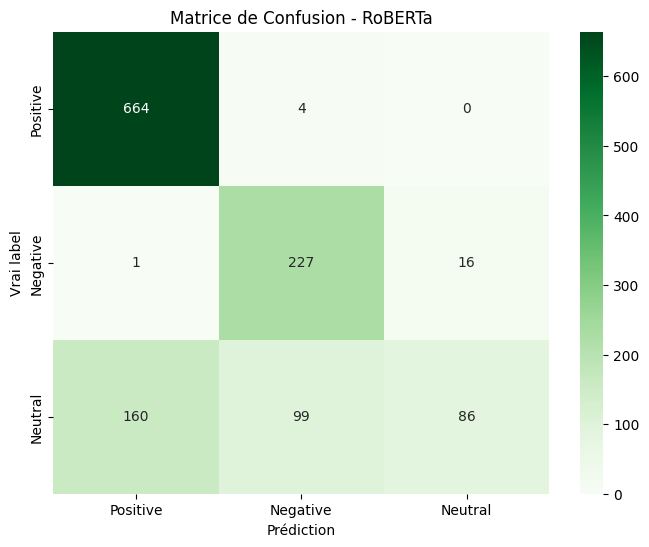

In [17]:


# Chargement des splits existants
X_test = pd.read_csv('../data/processed/X_test.csv')['review']
y_test = pd.read_csv('../data/processed/y_test.csv')['sentiment_label']



# Évaluation sur X_test
texts_test = X_test.astype(str).tolist()
df_test = pd.DataFrame({'review': X_test, 'sentiment_label': y_test})
df_test['roberta_sentiment'] = predict_sentiment_batch(texts_test)

y_true = df_test['sentiment_label']
y_pred = df_test['roberta_sentiment']

print("RoBERTa - Test Set")
print(classification_report(y_true, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=['Positive', 'Negative', 'Neutral'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Positive', 'Negative', 'Neutral'],
            yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Matrice de Confusion - RoBERTa')
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.show()


In [18]:
df.to_csv('../data/processed/results_roberta.csv', index=False)
print("Résultats RoBERTa sauvegardés dans data/processed/results_roberta.csv")


Résultats RoBERTa sauvegardés dans data/processed/results_roberta.csv


In [19]:
df_test.to_csv('../data/processed/results_roberta_test.csv', index=False)
print("Résultats RoBERTa sauvegardés dans data/processed/results_roberta_test.csv")

Résultats RoBERTa sauvegardés dans data/processed/results_roberta_test.csv
